In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
%cd /content/drive/MyDrive/Universidad/Aprendizaje Automático II/Práctica/Trabajos/FINAL/IMAGENES

/content/drive/MyDrive/AA II/NUEVO (1)


In [1]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Definir transformaciones para los datos de entrenamiento y validación
transformaciones = transforms.Compose([
    transforms.Resize((100, 100)),  # Redimensionar las imágenes
    transforms.ToTensor()  # Convertir las imágenes a tensores
])

# Cargar los datos de entrenamiento y validación
dataset_entrenamiento = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/train', transform=transformaciones)
dataset_validacion = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/validation', transform=transformaciones)
dataset_test = ImageFolder(root='/Users/alejandroalemanaleman/Downloads/AA2 - trabajo 1/test', transform=transformaciones)

In [2]:
import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_wts = copy.deepcopy(model.state_dict())
            self.counter = 0

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        # Capas convolucionales
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=2)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)  # Nueva capa convolucional

        # Batch Normalization para cada capa convolucional
        self.bn1 = nn.BatchNorm2d(num_features=16)
        self.bn2 = nn.BatchNorm2d(num_features=32)
        self.bn3 = nn.BatchNorm2d(num_features=64)
        self.bn4 = nn.BatchNorm2d(num_features=128)  # Normalización para la nueva capa

        # MaxPooling y Dropout
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.dropout_conv = nn.Dropout(p=0.25)  # Dropout para capas convolucionales
        self.dropout_fc = nn.Dropout(p=0.5)  # Dropout para capas densas

        # Capas completamente conectadas
        self.fc1 = nn.Linear(128 * 6 * 6, 256)  # Ajuste del tamaño según salida de la última capa convolucional
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, 7)  # Salida para 7 clases

        # Batch Normalization para capas densas
        self.fc_bn1 = nn.BatchNorm1d(256)
        self.fc_bn2 = nn.BatchNorm1d(128)
        self.fc_bn3 = nn.BatchNorm1d(64)
        self.fc_bn4 = nn.BatchNorm1d(32)

    def forward(self, x):
        # Pasos convolucionales con activación, normalización y pooling
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout_conv(x)

        x = self.pool(F.relu(self.bn4(self.conv4(x))))  # Nueva capa convolucional
        x = self.dropout_conv(x)

        # Aplanar para pasar a capas densas
        x = x.view(-1, 128 * 6 * 6)

        # Pasos densos con activación, normalización y dropout
        x = F.relu(self.fc_bn1(self.fc1(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn2(self.fc2(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn3(self.fc3(x)))
        x = self.dropout_fc(x)

        x = F.relu(self.fc_bn4(self.fc4(x)))
        x = self.dropout_fc(x)

        x = self.fc5(x)  # Sin activación final porque CrossEntropyLoss la incluye
        return x


In [4]:
def graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion):
    # Crear una figura con dos subgráficos en una fila
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Graficar la función de pérdida en el primer subgráfico
    ax[0].plot(valores_perdida, label='Pérdida')
    ax[0].set_xlabel('Épocas')
    ax[0].set_ylabel('Pérdida')
    ax[0].set_title(f'Función de Pérdida\n LR: {lr} Batch Size: {batch_size}')
    ax[0].legend()

    # Graficar las exactitudes en el segundo subgráfico
    ax[1].plot(exactitud_entrenamiento, label='Exactitud de Entrenamiento')
    ax[1].plot(exactitud_validacion, label='Exactitud de Validación')
    ax[1].set_xlabel('Épocas')
    ax[1].set_ylabel('Exactitud')
    ax[1].set_title(f'Exactitud de Entrenamiento y Validación\n LR: {lr} Batch Size: {batch_size}')
    ax[1].legend()

    # Ajustar espaciado entre los gráficos
    plt.tight_layout()

    # Mostrar los gráficos
    plt.show()

In [5]:
def calcular_exactitud_test(modelo, dataloader_test, device):
    correctas = 0
    total = 0
    with torch.no_grad():
        modelo.eval()

        for images, labels in dataloader_test:
            images, labels = images.to(device), labels.to(device)
            outputs = modelo(images)
            _, predicted = torch.max(outputs.data,1)
            total += labels.size(0)
            correctas += (predicted == labels).sum().item()
        #print(f'Exactitud de el modelo con las {total} imágenes de test: {100*correctas/total}%')
    return 100*correctas/total

In [6]:
def matriz_de_confusion(modelo, dataloader_test, device):

    modelo.eval()

    # Inicializar listas para etiquetas reales y predicciones
    predicciones_totales = []
    etiquetas_reales_totales = []

    # Verificar que el dataloader_test tiene datos
    if len(dataloader_test.dataset) == 0:
        print("El conjunto de test está vacío. Verifica los datos.")
    else:
        # Bucle para obtener predicciones
        with torch.no_grad():
            for imagenes, etiquetas in dataloader_test:
                imagenes, etiquetas = imagenes.to(device), etiquetas.to(device)
                salidas = modelo(imagenes)
                _, predicciones = torch.max(salidas, 1)
                predicciones_totales.extend(predicciones.cpu().numpy())
                etiquetas_reales_totales.extend(etiquetas.cpu().numpy())

    # Comprobar si se obtuvieron predicciones
    if len(etiquetas_reales_totales) > 0 and len(predicciones_totales) > 0:
        # Imprimir el reporte de clasificación
        print("Reporte de clasificación:")
        print(classification_report(etiquetas_reales_totales, predicciones_totales, digits=4))

        # Crear la matriz de confusión
        etiquetas_unicas = sorted(set(etiquetas_reales_totales))  # Identificar las clases presentes
        matriz_confusion_test = confusion_matrix(etiquetas_reales_totales, predicciones_totales, labels=etiquetas_unicas)

        # Visualizar la matriz de confusión
        plt.figure(figsize=(10, 8))
        sns.heatmap(matriz_confusion_test, annot=True, fmt='d', cmap='Blues', xticklabels=etiquetas_unicas, yticklabels=etiquetas_unicas)
        plt.xlabel('Predicciones')
        plt.ylabel('Etiquetas Reales')
        plt.title('Matriz de Confusión del Conjunto de Test')
        plt.show()

        # Mostrar las clases presentes
        clases_presentes = set(etiquetas_reales_totales)
        print(f"Clases presentes en el conjunto de test: {clases_presentes}")
    else:
        print("No se encontraron datos válidos para generar predicciones o etiquetas.")


Entrenando con lr=0.005, batch_size=32, epochs=15
    Época 1, pérdida: 1.8118, exactitud entrenamiento: 27.51%, exactitud validación: 27.71%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.6255, exactitud entrenamiento: 39.59%, exactitud validación: 39.17%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.5370, exactitud entrenamiento: 47.07%, exactitud validación: 45.50%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.4552, exactitud entrenamiento: 47.47%, exactitud validación: 46.70%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.4067, exactitud entrenamiento: 46.67%, exactitud validación: 45.96%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.3530, exactitud entrenamiento: 50.99%, exactitud validación: 50.46%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.2767, exactitud entrenamiento: 62.48%, exactitud validación: 61.28%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.2046, exactitud entrenamiento: 60.20%, exactitud validación: 56.

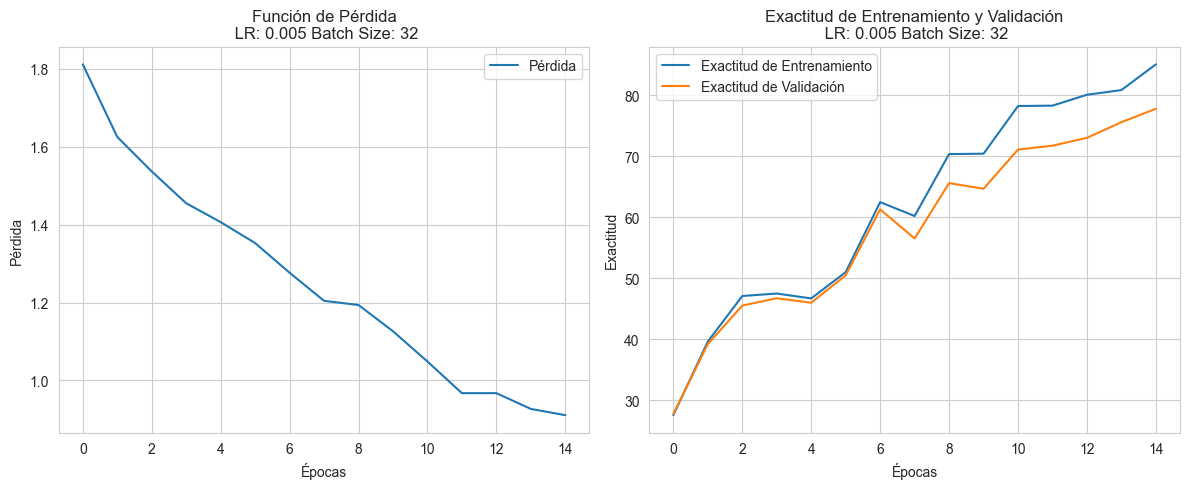


Entrenando con lr=0.005, batch_size=32, epochs=30
    Época 1, pérdida: 1.7912, exactitud entrenamiento: 32.99%, exactitud validación: 31.01%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5526, exactitud entrenamiento: 50.09%, exactitud validación: 49.17%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4432, exactitud entrenamiento: 32.01%, exactitud validación: 32.11%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.3508, exactitud entrenamiento: 50.15%, exactitud validación: 50.92%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.2726, exactitud entrenamiento: 61.83%, exactitud validación: 58.26%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2133, exactitud entrenamiento: 57.61%, exactitud validación: 57.98%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.1659, exactitud entrenamiento: 65.37%, exactitud validación: 61.01%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1379, exactitud entrenamiento: 65.03%, exactitud validación: 65.

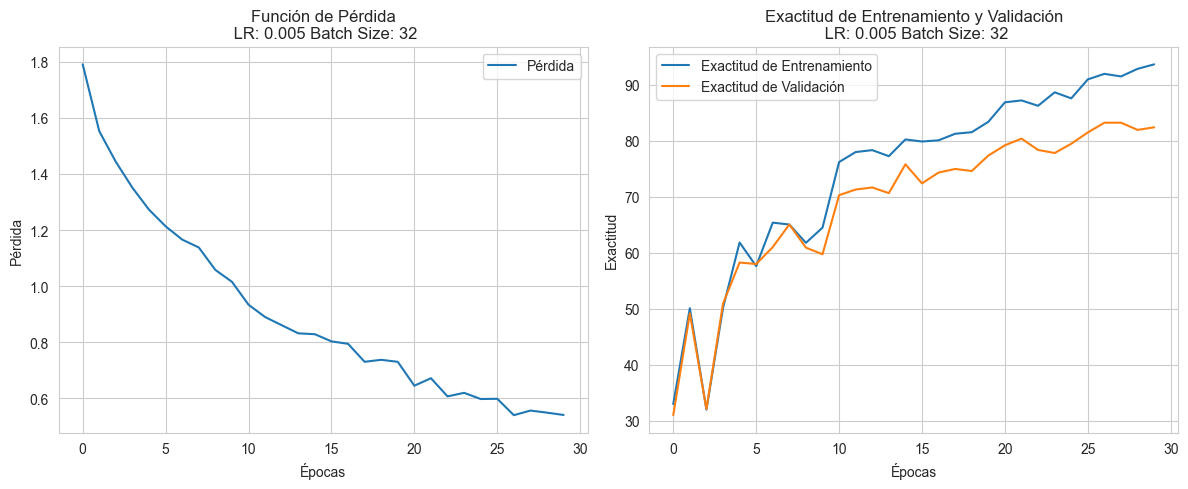


Entrenando con lr=0.005, batch_size=64, epochs=15
    Época 1, pérdida: 1.8628, exactitud entrenamiento: 15.25%, exactitud validación: 15.05%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.6160, exactitud entrenamiento: 30.07%, exactitud validación: 31.47%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4585, exactitud entrenamiento: 18.45%, exactitud validación: 19.72%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.3810, exactitud entrenamiento: 45.47%, exactitud validación: 47.25%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.2946, exactitud entrenamiento: 46.98%, exactitud validación: 46.97%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2600, exactitud entrenamiento: 49.32%, exactitud validación: 49.82%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.2047, exactitud entrenamiento: 55.67%, exactitud validación: 53.39%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1634, exactitud entrenamiento: 60.04%, exactitud validación: 58.

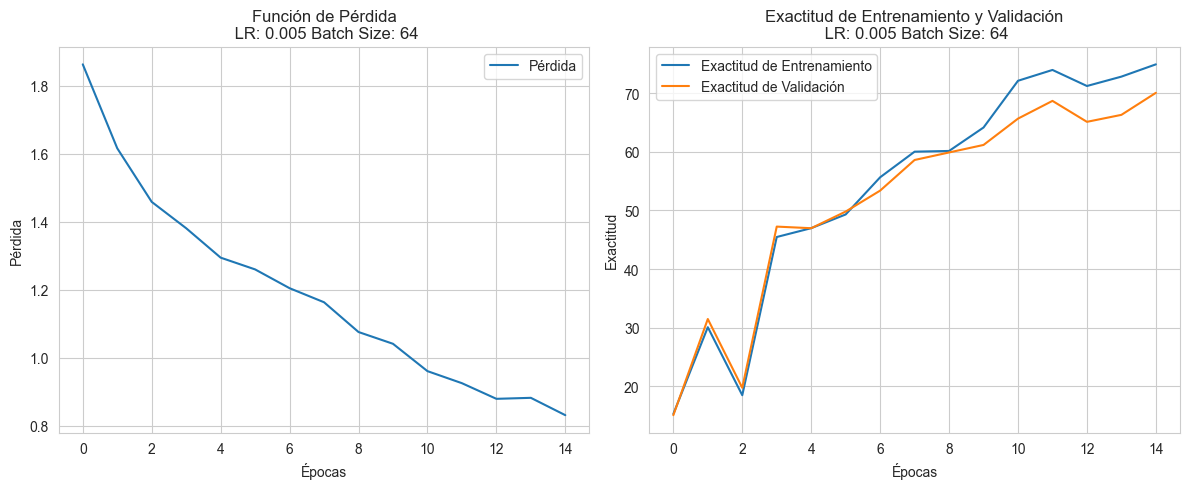


Entrenando con lr=0.005, batch_size=64, epochs=30
    Época 1, pérdida: 1.8536, exactitud entrenamiento: 39.56%, exactitud validación: 39.91%
Learning rate actual: 0.005000
    Época 2, pérdida: 1.5795, exactitud entrenamiento: 20.24%, exactitud validación: 20.37%
Learning rate actual: 0.005000
    Época 3, pérdida: 1.4827, exactitud entrenamiento: 35.77%, exactitud validación: 33.30%
Learning rate actual: 0.005000
    Época 4, pérdida: 1.4105, exactitud entrenamiento: 50.74%, exactitud validación: 49.54%
Learning rate actual: 0.005000
    Época 5, pérdida: 1.3195, exactitud entrenamiento: 53.70%, exactitud validación: 52.57%
Learning rate actual: 0.005000
    Época 6, pérdida: 1.2593, exactitud entrenamiento: 62.94%, exactitud validación: 61.56%
Learning rate actual: 0.005000
    Época 7, pérdida: 1.2427, exactitud entrenamiento: 64.20%, exactitud validación: 61.93%
Learning rate actual: 0.005000
    Época 8, pérdida: 1.1772, exactitud entrenamiento: 65.71%, exactitud validación: 61.

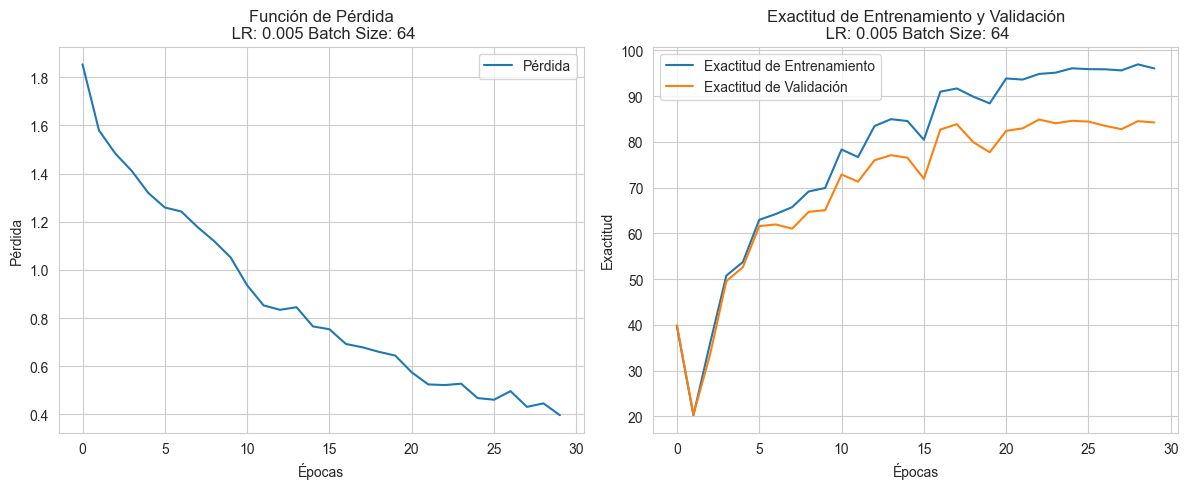


Entrenando con lr=0.001, batch_size=32, epochs=15
    Época 1, pérdida: 1.9240, exactitud entrenamiento: 22.49%, exactitud validación: 20.83%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.7171, exactitud entrenamiento: 25.42%, exactitud validación: 24.22%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.5895, exactitud entrenamiento: 36.14%, exactitud validación: 35.78%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.4915, exactitud entrenamiento: 44.55%, exactitud validación: 43.94%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4275, exactitud entrenamiento: 55.33%, exactitud validación: 52.94%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3222, exactitud entrenamiento: 54.65%, exactitud validación: 52.29%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2515, exactitud entrenamiento: 59.95%, exactitud validación: 58.17%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2160, exactitud entrenamiento: 58.53%, exactitud validación: 56.

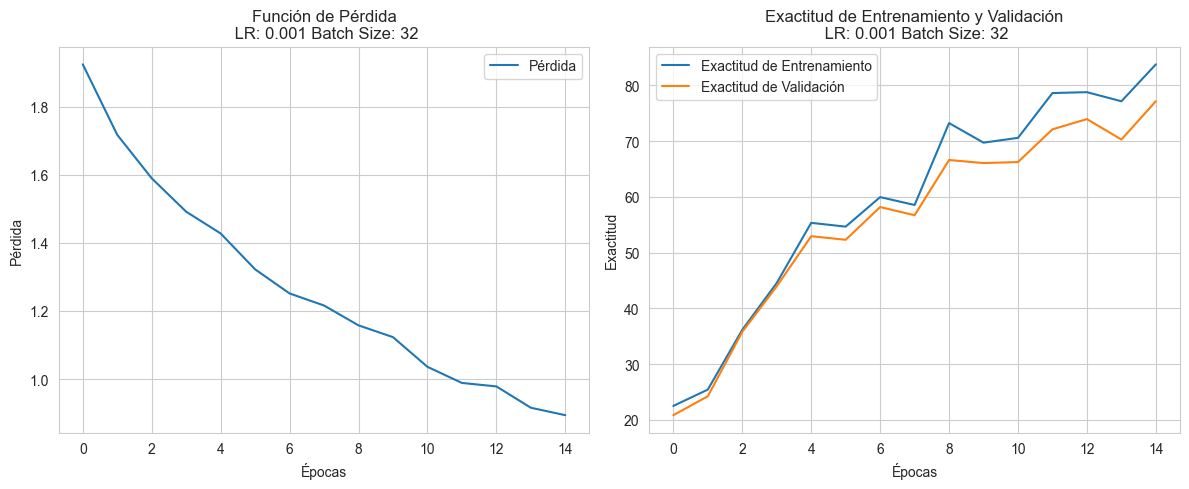


Entrenando con lr=0.001, batch_size=32, epochs=30
    Época 1, pérdida: 1.9495, exactitud entrenamiento: 26.40%, exactitud validación: 25.78%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.7597, exactitud entrenamiento: 27.23%, exactitud validación: 27.06%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.6178, exactitud entrenamiento: 37.52%, exactitud validación: 37.25%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.5140, exactitud entrenamiento: 45.01%, exactitud validación: 43.49%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4517, exactitud entrenamiento: 31.08%, exactitud validación: 30.83%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3611, exactitud entrenamiento: 56.25%, exactitud validación: 56.42%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.3079, exactitud entrenamiento: 59.98%, exactitud validación: 58.26%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2548, exactitud entrenamiento: 60.44%, exactitud validación: 59.

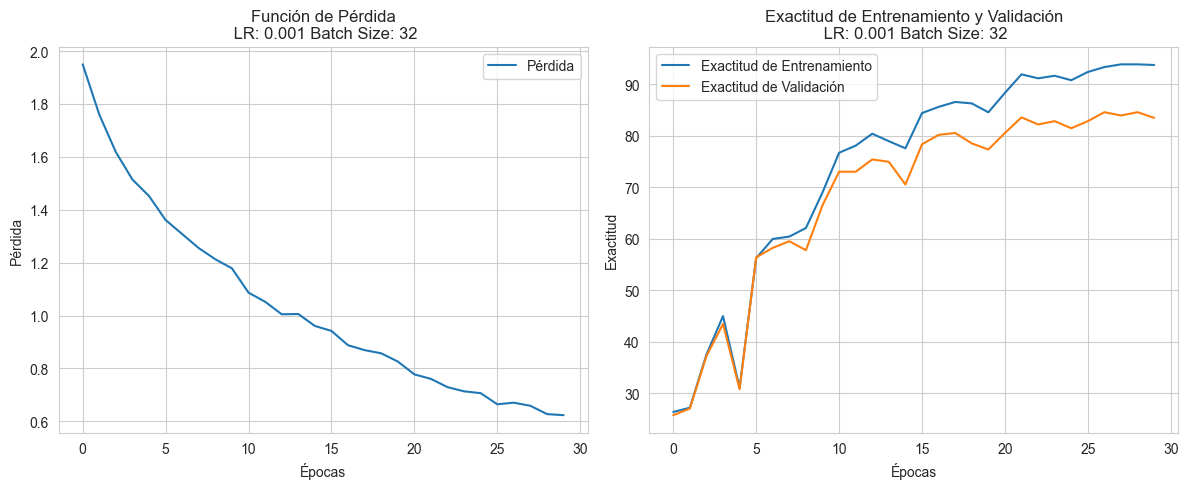


Entrenando con lr=0.001, batch_size=64, epochs=15
    Época 1, pérdida: 1.9876, exactitud entrenamiento: 17.07%, exactitud validación: 16.24%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.8187, exactitud entrenamiento: 30.59%, exactitud validación: 31.65%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.6808, exactitud entrenamiento: 25.75%, exactitud validación: 26.15%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.5809, exactitud entrenamiento: 30.84%, exactitud validación: 29.54%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4893, exactitud entrenamiento: 46.95%, exactitud validación: 46.33%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.4024, exactitud entrenamiento: 50.92%, exactitud validación: 52.02%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.3224, exactitud entrenamiento: 41.31%, exactitud validación: 41.28%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2669, exactitud entrenamiento: 60.97%, exactitud validación: 58.

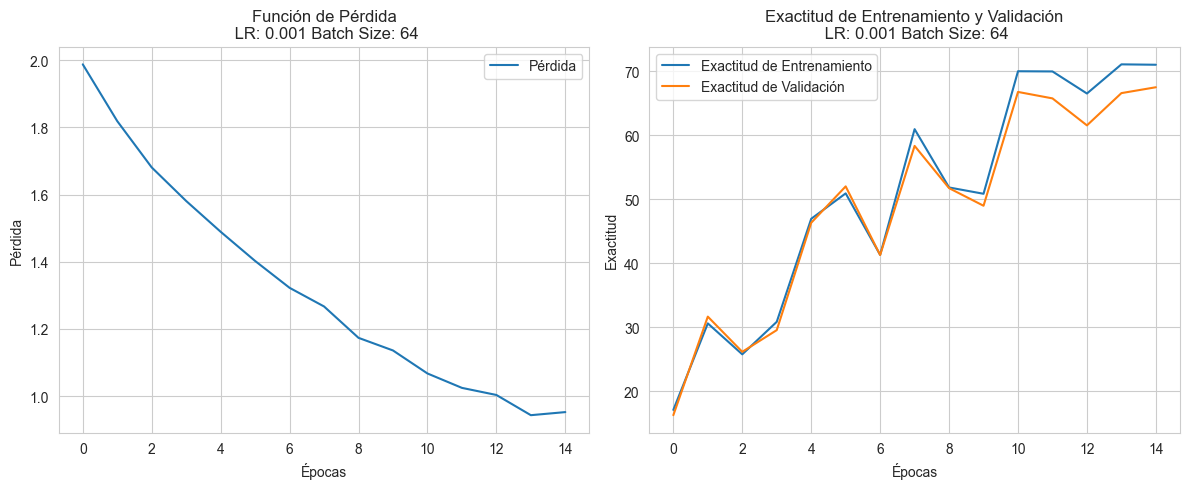


Entrenando con lr=0.001, batch_size=64, epochs=30
    Época 1, pérdida: 1.9605, exactitud entrenamiento: 21.13%, exactitud validación: 20.64%
Learning rate actual: 0.001000
    Época 2, pérdida: 1.7679, exactitud entrenamiento: 20.61%, exactitud validación: 21.01%
Learning rate actual: 0.001000
    Época 3, pérdida: 1.6214, exactitud entrenamiento: 19.99%, exactitud validación: 21.19%
Learning rate actual: 0.001000
    Época 4, pérdida: 1.5310, exactitud entrenamiento: 43.10%, exactitud validación: 41.19%
Learning rate actual: 0.001000
    Época 5, pérdida: 1.4618, exactitud entrenamiento: 44.21%, exactitud validación: 42.94%
Learning rate actual: 0.001000
    Época 6, pérdida: 1.3605, exactitud entrenamiento: 48.77%, exactitud validación: 45.23%
Learning rate actual: 0.001000
    Época 7, pérdida: 1.2696, exactitud entrenamiento: 65.28%, exactitud validación: 62.02%
Learning rate actual: 0.001000
    Época 8, pérdida: 1.2284, exactitud entrenamiento: 50.49%, exactitud validación: 47.

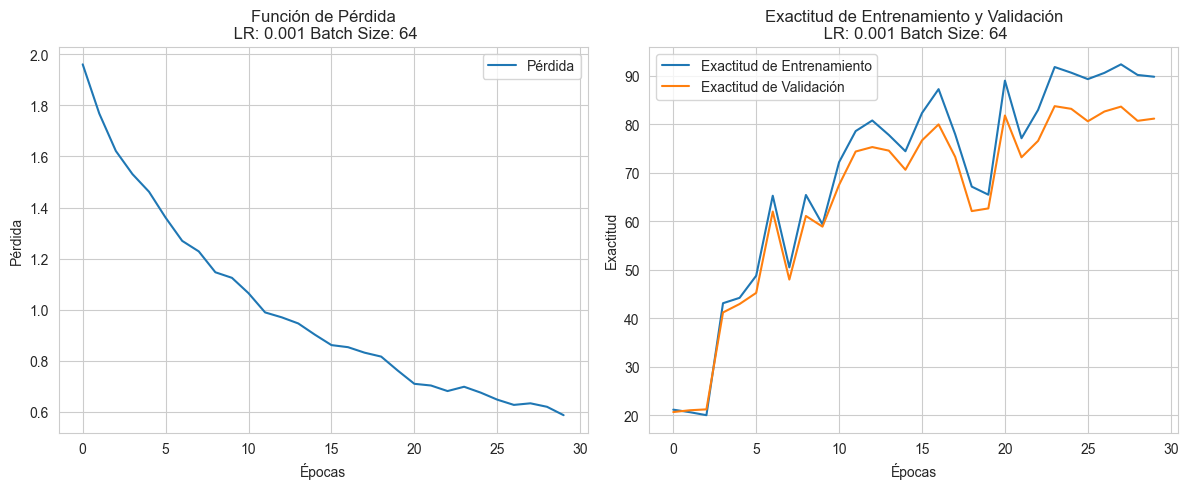


Entrenando con lr=0.0005, batch_size=32, epochs=15
    Época 1, pérdida: 2.0206, exactitud entrenamiento: 14.17%, exactitud validación: 14.04%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.8730, exactitud entrenamiento: 20.86%, exactitud validación: 21.10%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.7527, exactitud entrenamiento: 24.83%, exactitud validación: 25.50%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.6618, exactitud entrenamiento: 28.13%, exactitud validación: 28.35%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5553, exactitud entrenamiento: 37.43%, exactitud validación: 37.34%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4651, exactitud entrenamiento: 26.40%, exactitud validación: 25.23%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.3924, exactitud entrenamiento: 34.60%, exactitud validación: 33.21%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3097, exactitud entrenamiento: 51.91%, exactitud validación: 51

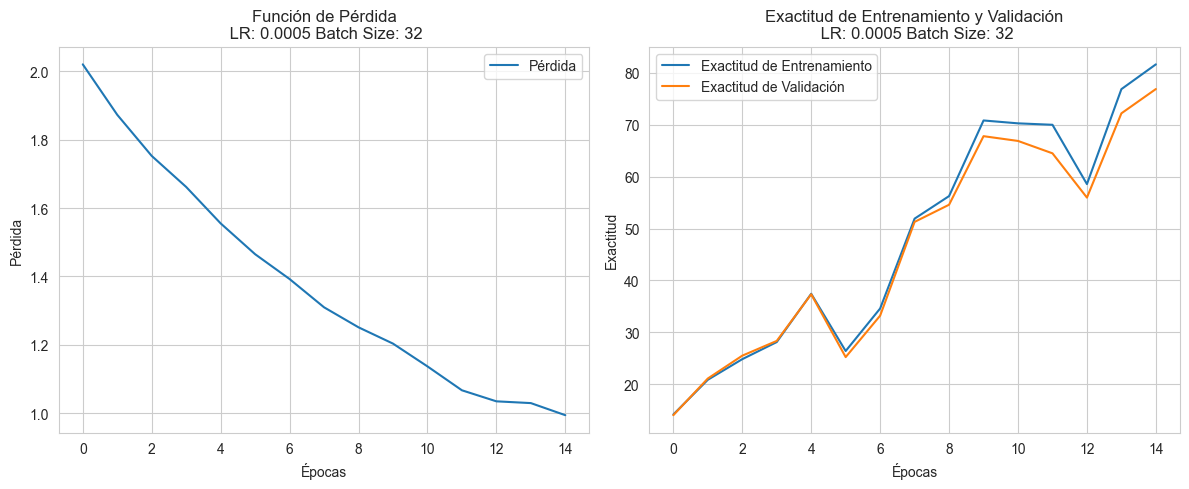


Entrenando con lr=0.0005, batch_size=32, epochs=30
    Época 1, pérdida: 1.9881, exactitud entrenamiento: 15.83%, exactitud validación: 15.23%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.8513, exactitud entrenamiento: 16.11%, exactitud validación: 15.50%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.7311, exactitud entrenamiento: 17.13%, exactitud validación: 16.88%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.6498, exactitud entrenamiento: 18.70%, exactitud validación: 18.35%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.5609, exactitud entrenamiento: 28.53%, exactitud validación: 28.90%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.4799, exactitud entrenamiento: 34.47%, exactitud validación: 34.31%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4156, exactitud entrenamiento: 50.18%, exactitud validación: 49.72%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.3372, exactitud entrenamiento: 67.04%, exactitud validación: 64

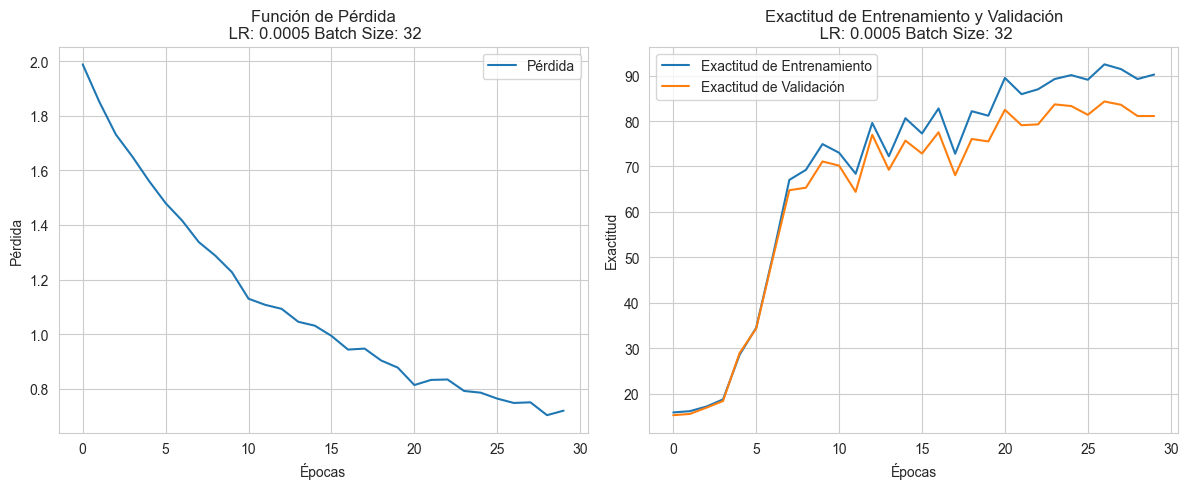


Entrenando con lr=0.0005, batch_size=64, epochs=15
    Época 1, pérdida: 2.0321, exactitud entrenamiento: 16.97%, exactitud validación: 16.06%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.9210, exactitud entrenamiento: 20.30%, exactitud validación: 20.18%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.8170, exactitud entrenamiento: 18.05%, exactitud validación: 17.61%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.7249, exactitud entrenamiento: 25.20%, exactitud validación: 26.42%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.6359, exactitud entrenamiento: 22.52%, exactitud validación: 22.57%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.5686, exactitud entrenamiento: 19.99%, exactitud validación: 19.54%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.5065, exactitud entrenamiento: 32.96%, exactitud validación: 32.02%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.4230, exactitud entrenamiento: 36.14%, exactitud validación: 34

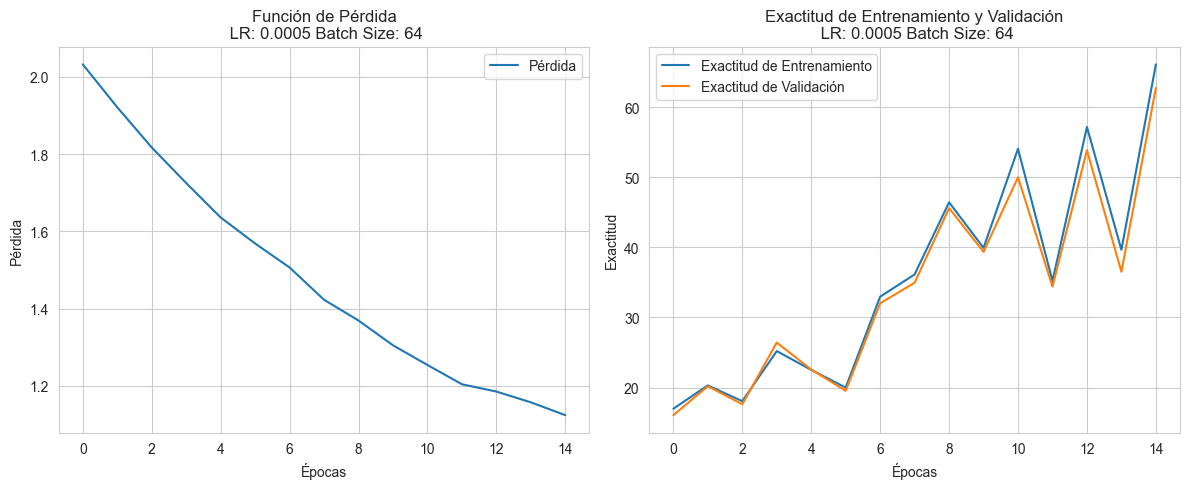


Entrenando con lr=0.0005, batch_size=64, epochs=30
    Época 1, pérdida: 2.0010, exactitud entrenamiento: 22.64%, exactitud validación: 21.19%
Learning rate actual: 0.000500
    Época 2, pérdida: 1.9217, exactitud entrenamiento: 23.11%, exactitud validación: 23.03%
Learning rate actual: 0.000500
    Época 3, pérdida: 1.8127, exactitud entrenamiento: 16.39%, exactitud validación: 15.96%
Learning rate actual: 0.000500
    Época 4, pérdida: 1.7233, exactitud entrenamiento: 32.16%, exactitud validación: 33.39%
Learning rate actual: 0.000500
    Época 5, pérdida: 1.6411, exactitud entrenamiento: 32.99%, exactitud validación: 32.11%
Learning rate actual: 0.000500
    Época 6, pérdida: 1.5585, exactitud entrenamiento: 42.98%, exactitud validación: 42.94%
Learning rate actual: 0.000500
    Época 7, pérdida: 1.4825, exactitud entrenamiento: 39.65%, exactitud validación: 40.55%
Learning rate actual: 0.000500
    Época 8, pérdida: 1.4171, exactitud entrenamiento: 54.53%, exactitud validación: 51

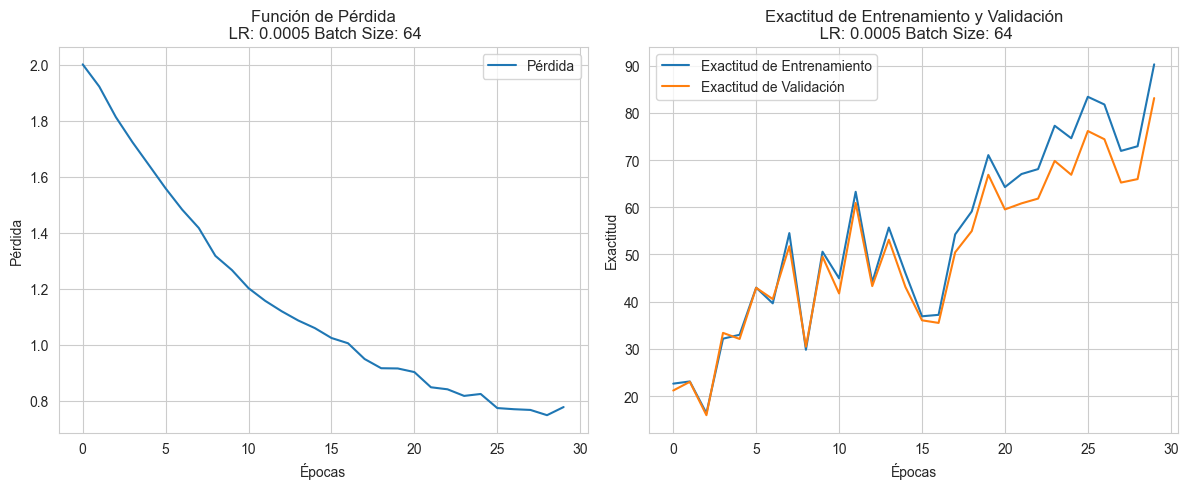


Entrenando con lr=0.0001, batch_size=32, epochs=15
    Época 1, pérdida: 2.0383, exactitud entrenamiento: 13.92%, exactitud validación: 13.85%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9821, exactitud entrenamiento: 15.59%, exactitud validación: 15.69%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9544, exactitud entrenamiento: 19.59%, exactitud validación: 18.90%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.9089, exactitud entrenamiento: 21.44%, exactitud validación: 21.10%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8824, exactitud entrenamiento: 19.84%, exactitud validación: 19.82%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8526, exactitud entrenamiento: 17.74%, exactitud validación: 17.16%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.8251, exactitud entrenamiento: 21.84%, exactitud validación: 21.28%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7992, exactitud entrenamiento: 21.84%, exactitud validación: 21

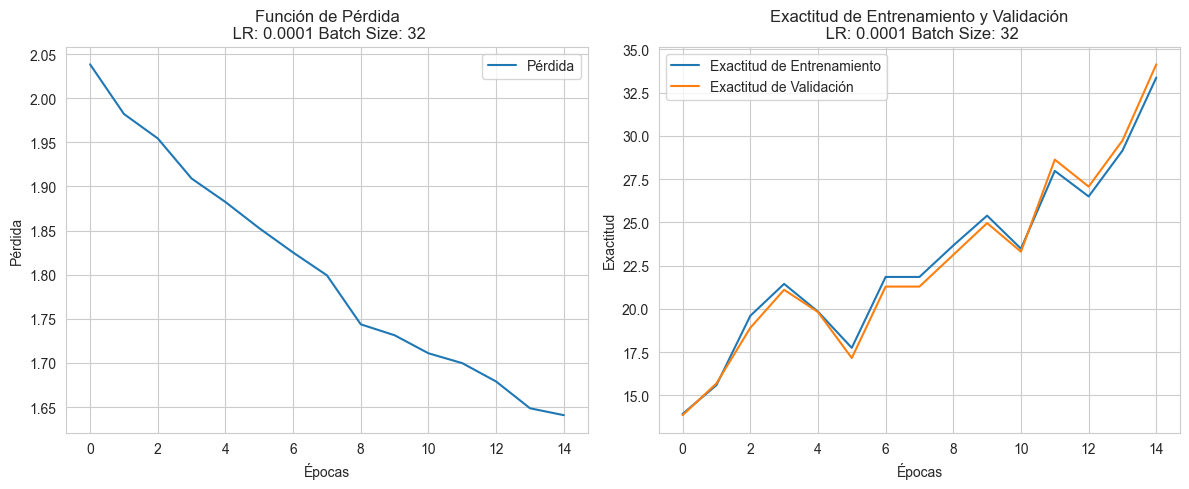


Entrenando con lr=0.0001, batch_size=32, epochs=30
    Época 1, pérdida: 2.0281, exactitud entrenamiento: 13.99%, exactitud validación: 13.58%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9656, exactitud entrenamiento: 13.89%, exactitud validación: 13.94%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9182, exactitud entrenamiento: 17.99%, exactitud validación: 18.07%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.8938, exactitud entrenamiento: 20.30%, exactitud validación: 21.65%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8432, exactitud entrenamiento: 19.16%, exactitud validación: 18.99%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8153, exactitud entrenamiento: 18.73%, exactitud validación: 18.72%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.7708, exactitud entrenamiento: 18.55%, exactitud validación: 18.53%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.7291, exactitud entrenamiento: 21.66%, exactitud validación: 21

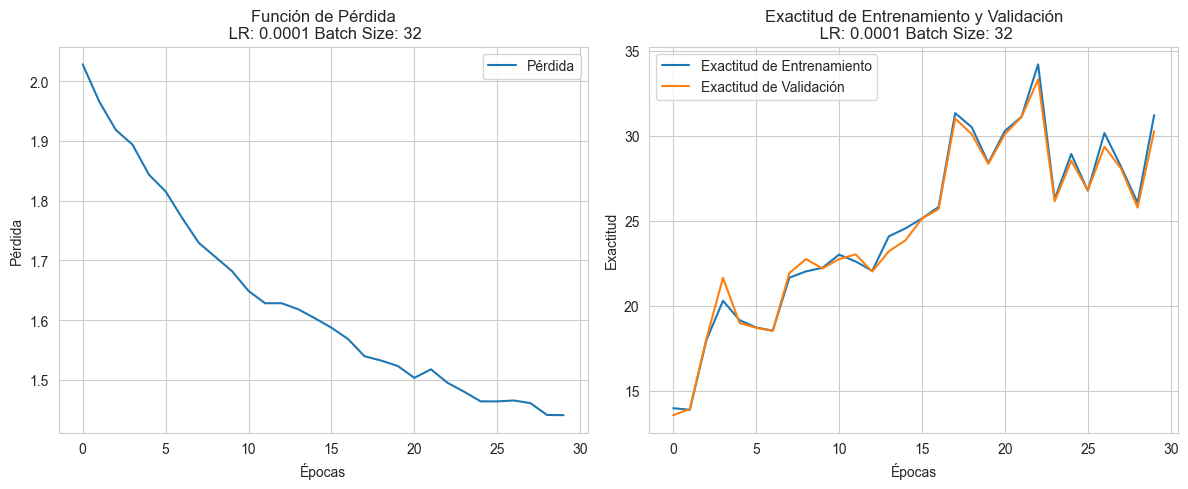


Entrenando con lr=0.0001, batch_size=64, epochs=15
    Época 1, pérdida: 2.0538, exactitud entrenamiento: 18.73%, exactitud validación: 18.62%
Learning rate actual: 0.000100
    Época 2, pérdida: 1.9874, exactitud entrenamiento: 15.62%, exactitud validación: 15.78%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9588, exactitud entrenamiento: 23.48%, exactitud validación: 24.50%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.9200, exactitud entrenamiento: 22.74%, exactitud validación: 23.03%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.8959, exactitud entrenamiento: 20.33%, exactitud validación: 20.28%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8775, exactitud entrenamiento: 14.79%, exactitud validación: 14.77%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.8454, exactitud entrenamiento: 21.20%, exactitud validación: 22.11%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.8292, exactitud entrenamiento: 20.55%, exactitud validación: 20

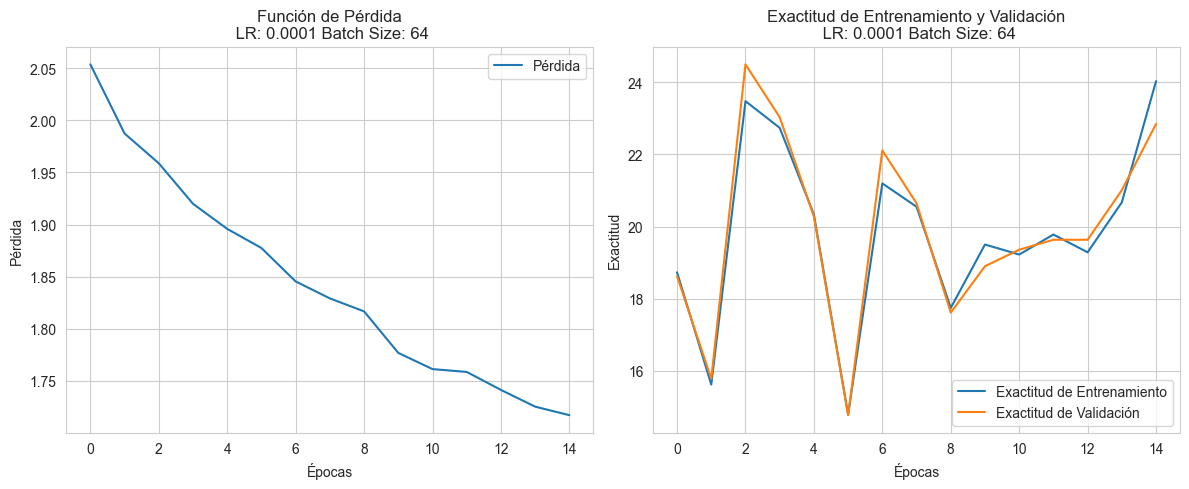


Entrenando con lr=0.0001, batch_size=64, epochs=30
    Época 1, pérdida: 2.0720, exactitud entrenamiento: 20.83%, exactitud validación: 19.91%
Learning rate actual: 0.000100
    Época 2, pérdida: 2.0120, exactitud entrenamiento: 22.18%, exactitud validación: 21.38%
Learning rate actual: 0.000100
    Época 3, pérdida: 1.9630, exactitud entrenamiento: 19.44%, exactitud validación: 18.26%
Learning rate actual: 0.000100
    Época 4, pérdida: 1.9316, exactitud entrenamiento: 22.83%, exactitud validación: 22.29%
Learning rate actual: 0.000100
    Época 5, pérdida: 1.9065, exactitud entrenamiento: 19.32%, exactitud validación: 18.44%
Learning rate actual: 0.000100
    Época 6, pérdida: 1.8948, exactitud entrenamiento: 22.18%, exactitud validación: 22.39%
Learning rate actual: 0.000100
    Época 7, pérdida: 1.8638, exactitud entrenamiento: 22.83%, exactitud validación: 22.66%
Learning rate actual: 0.000100
    Época 8, pérdida: 1.8461, exactitud entrenamiento: 22.92%, exactitud validación: 23

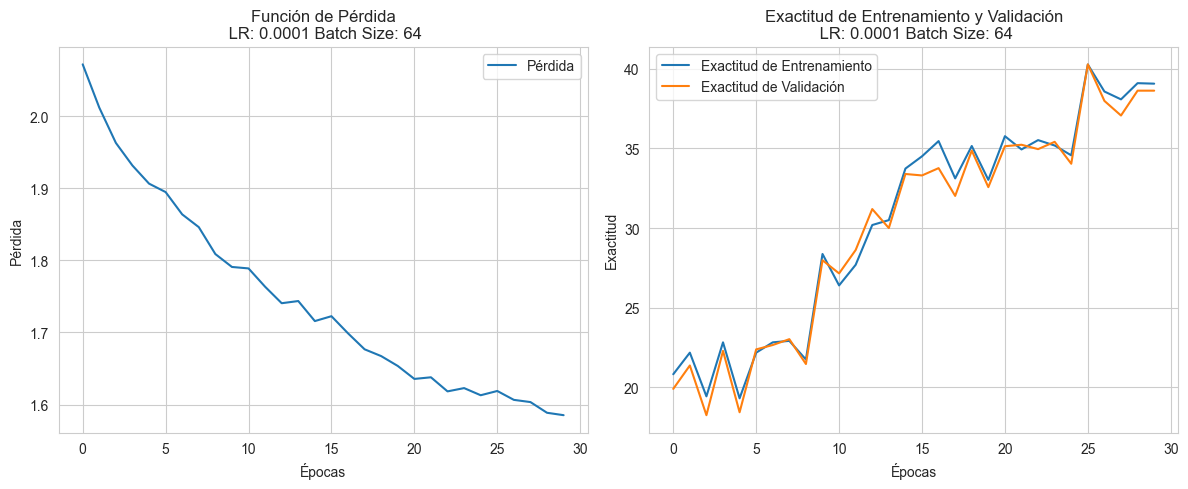


Entrenando con lr=5e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0989, exactitud entrenamiento: 19.75%, exactitud validación: 18.72%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0506, exactitud entrenamiento: 19.01%, exactitud validación: 20.46%
Learning rate actual: 0.000050
    Época 3, pérdida: 2.0177, exactitud entrenamiento: 15.50%, exactitud validación: 15.41%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9998, exactitud entrenamiento: 15.00%, exactitud validación: 15.32%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9564, exactitud entrenamiento: 16.08%, exactitud validación: 15.69%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9232, exactitud entrenamiento: 17.16%, exactitud validación: 16.79%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.9068, exactitud entrenamiento: 18.30%, exactitud validación: 17.52%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8822, exactitud entrenamiento: 23.20%, exactitud validación: 22.

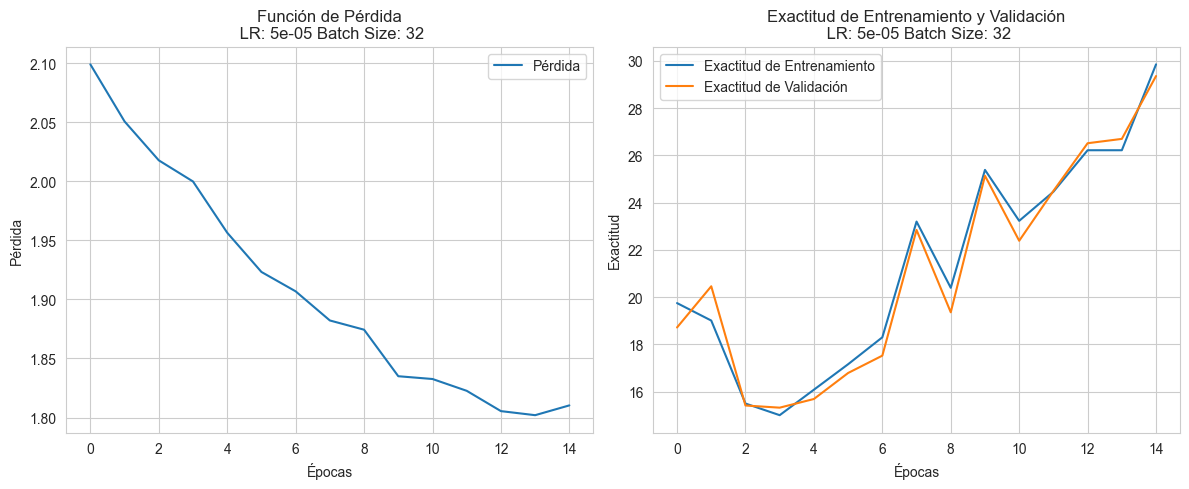


Entrenando con lr=5e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0594, exactitud entrenamiento: 13.92%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0080, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 3, pérdida: 1.9830, exactitud entrenamiento: 14.20%, exactitud validación: 14.04%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9475, exactitud entrenamiento: 13.99%, exactitud validación: 14.13%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9348, exactitud entrenamiento: 13.86%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9225, exactitud entrenamiento: 14.29%, exactitud validación: 14.86%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.8945, exactitud entrenamiento: 18.24%, exactitud validación: 17.61%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.8629, exactitud entrenamiento: 17.53%, exactitud validación: 17.

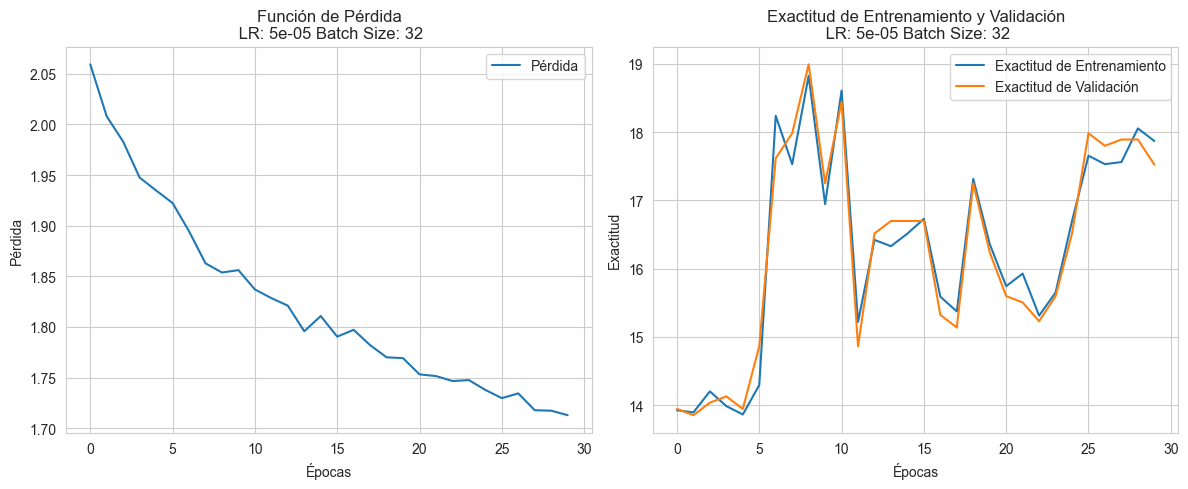


Entrenando con lr=5e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0763, exactitud entrenamiento: 16.54%, exactitud validación: 16.97%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0566, exactitud entrenamiento: 14.97%, exactitud validación: 14.86%
Learning rate actual: 0.000050
    Época 3, pérdida: 2.0338, exactitud entrenamiento: 18.79%, exactitud validación: 18.26%
Learning rate actual: 0.000050
    Época 4, pérdida: 2.0052, exactitud entrenamiento: 21.23%, exactitud validación: 20.64%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9951, exactitud entrenamiento: 25.69%, exactitud validación: 25.32%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9915, exactitud entrenamiento: 18.39%, exactitud validación: 18.26%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.9673, exactitud entrenamiento: 17.53%, exactitud validación: 17.06%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.9540, exactitud entrenamiento: 17.68%, exactitud validación: 17.

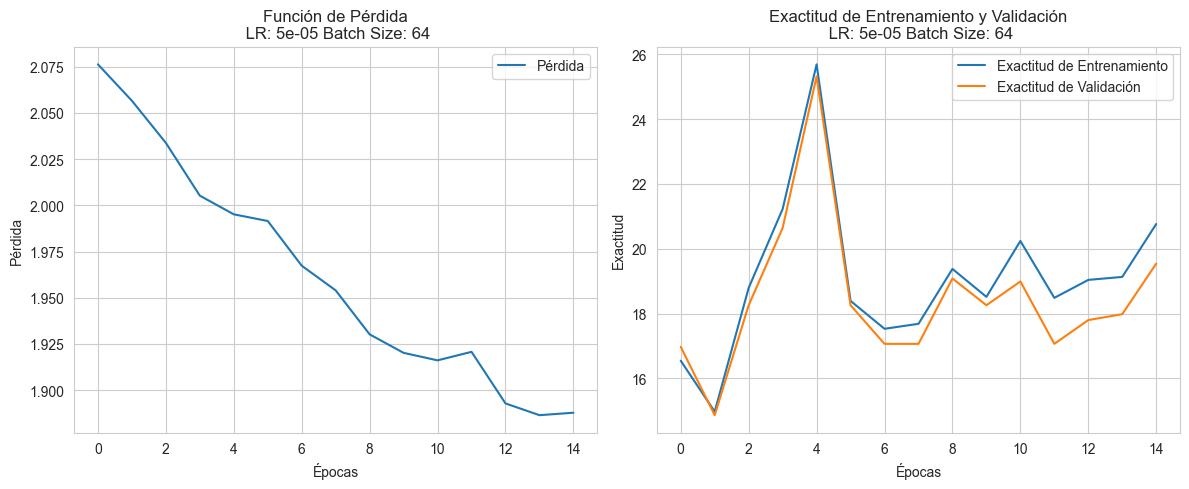


Entrenando con lr=5e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0388, exactitud entrenamiento: 18.76%, exactitud validación: 18.35%
Learning rate actual: 0.000050
    Época 2, pérdida: 2.0398, exactitud entrenamiento: 17.56%, exactitud validación: 16.88%
Learning rate actual: 0.000050
    Época 3, pérdida: 2.0057, exactitud entrenamiento: 14.02%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 4, pérdida: 1.9947, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 5, pérdida: 1.9653, exactitud entrenamiento: 13.96%, exactitud validación: 13.94%
Learning rate actual: 0.000050
    Época 6, pérdida: 1.9496, exactitud entrenamiento: 13.89%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 7, pérdida: 1.9416, exactitud entrenamiento: 13.92%, exactitud validación: 13.85%
Learning rate actual: 0.000050
    Época 8, pérdida: 1.9253, exactitud entrenamiento: 13.89%, exactitud validación: 13.

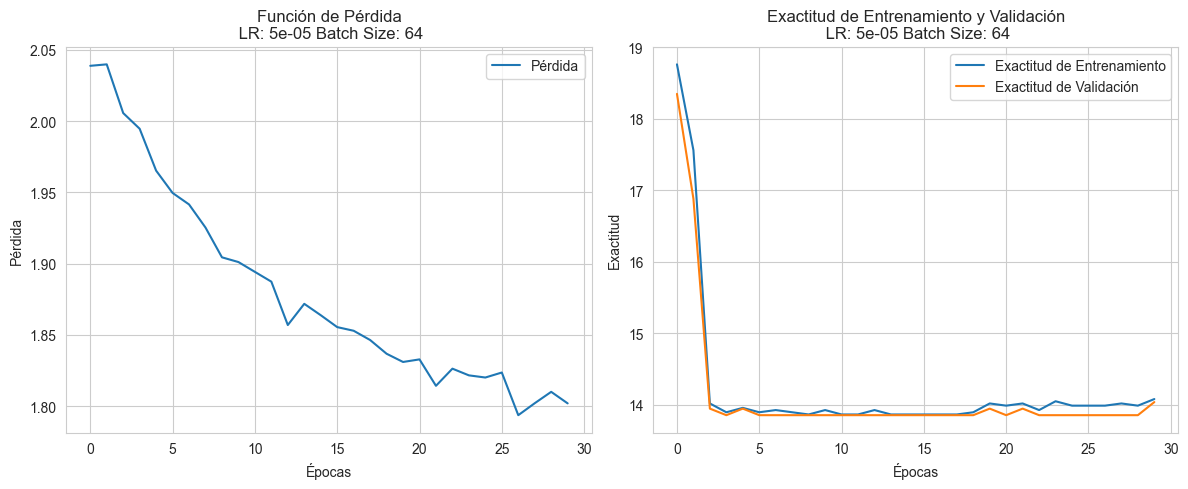


Entrenando con lr=1e-05, batch_size=32, epochs=15
    Época 1, pérdida: 2.0674, exactitud entrenamiento: 12.01%, exactitud validación: 11.47%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0440, exactitud entrenamiento: 14.79%, exactitud validación: 13.76%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0498, exactitud entrenamiento: 14.08%, exactitud validación: 12.94%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0417, exactitud entrenamiento: 14.94%, exactitud validación: 14.13%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0207, exactitud entrenamiento: 13.62%, exactitud validación: 13.49%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0319, exactitud entrenamiento: 13.43%, exactitud validación: 12.84%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0204, exactitud entrenamiento: 14.63%, exactitud validación: 13.94%
Learning rate actual: 0.000010
    Época 8, pérdida: 2.0119, exactitud entrenamiento: 14.14%, exactitud validación: 13.

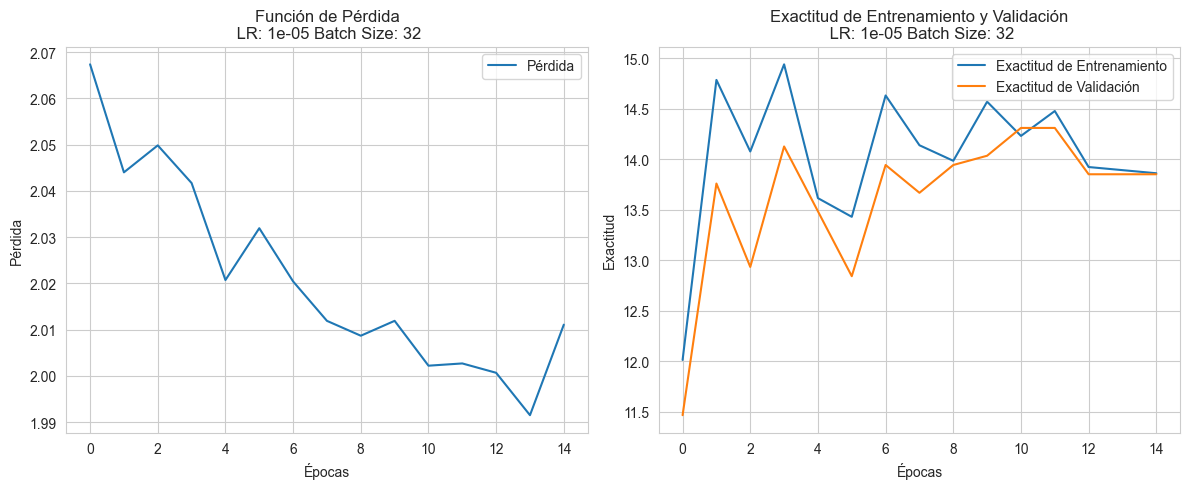


Entrenando con lr=1e-05, batch_size=32, epochs=30
    Época 1, pérdida: 2.0750, exactitud entrenamiento: 17.84%, exactitud validación: 16.79%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0396, exactitud entrenamiento: 16.76%, exactitud validación: 15.32%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0512, exactitud entrenamiento: 16.42%, exactitud validación: 14.68%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0370, exactitud entrenamiento: 17.62%, exactitud validación: 16.24%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0307, exactitud entrenamiento: 17.13%, exactitud validación: 16.51%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0269, exactitud entrenamiento: 18.45%, exactitud validación: 17.61%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0059, exactitud entrenamiento: 18.82%, exactitud validación: 17.61%
Learning rate actual: 0.000010
    Época 8, pérdida: 1.9885, exactitud entrenamiento: 15.00%, exactitud validación: 14.

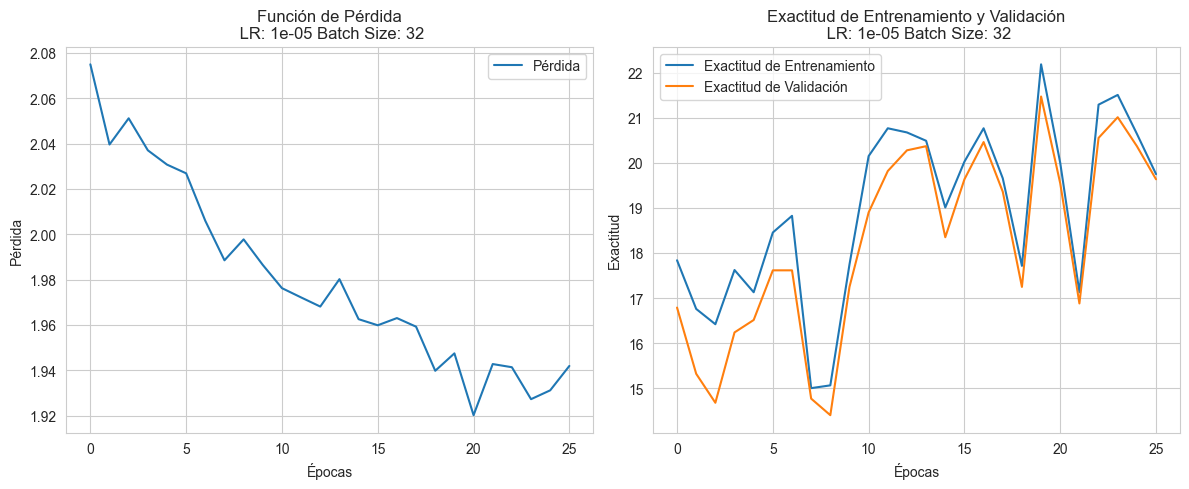


Entrenando con lr=1e-05, batch_size=64, epochs=15
    Época 1, pérdida: 2.0881, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0800, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0650, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0610, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0714, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0683, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0735, exactitud entrenamiento: 14.05%, exactitud validación: 14.04%
Learning rate actual: 0.000010
Parada anticipada activada


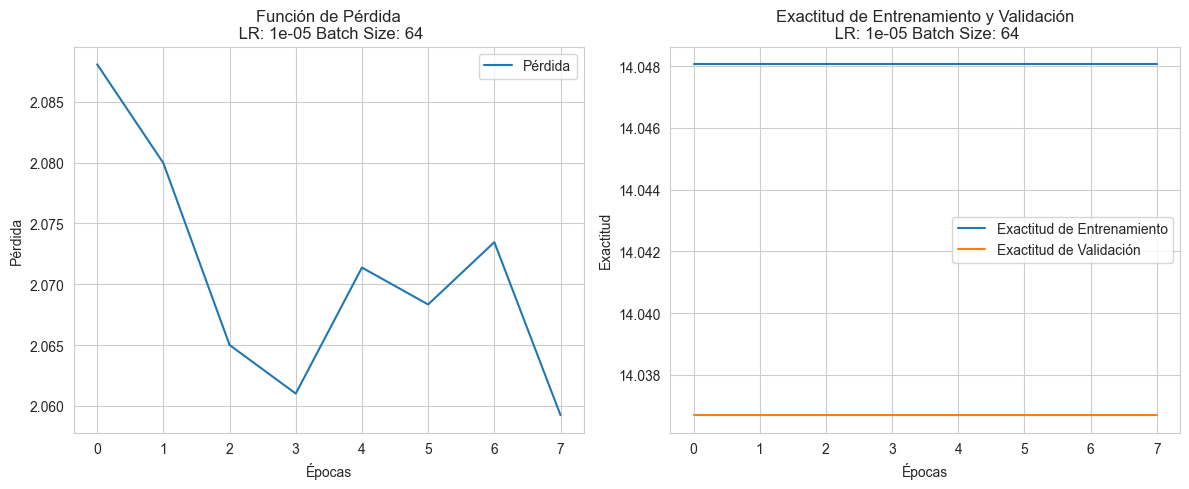


Entrenando con lr=1e-05, batch_size=64, epochs=30
    Época 1, pérdida: 2.0701, exactitud entrenamiento: 16.11%, exactitud validación: 16.15%
Learning rate actual: 0.000010
    Época 2, pérdida: 2.0697, exactitud entrenamiento: 16.79%, exactitud validación: 16.70%
Learning rate actual: 0.000010
    Época 3, pérdida: 2.0575, exactitud entrenamiento: 16.64%, exactitud validación: 16.51%
Learning rate actual: 0.000010
    Época 4, pérdida: 2.0414, exactitud entrenamiento: 20.39%, exactitud validación: 20.28%
Learning rate actual: 0.000010
    Época 5, pérdida: 2.0412, exactitud entrenamiento: 21.78%, exactitud validación: 23.30%
Learning rate actual: 0.000010
    Época 6, pérdida: 2.0456, exactitud entrenamiento: 22.30%, exactitud validación: 22.39%
Learning rate actual: 0.000010
    Época 7, pérdida: 2.0389, exactitud entrenamiento: 21.01%, exactitud validación: 21.93%
Learning rate actual: 0.000010
    Época 8, pérdida: 2.0424, exactitud entrenamiento: 19.35%, exactitud validación: 19.

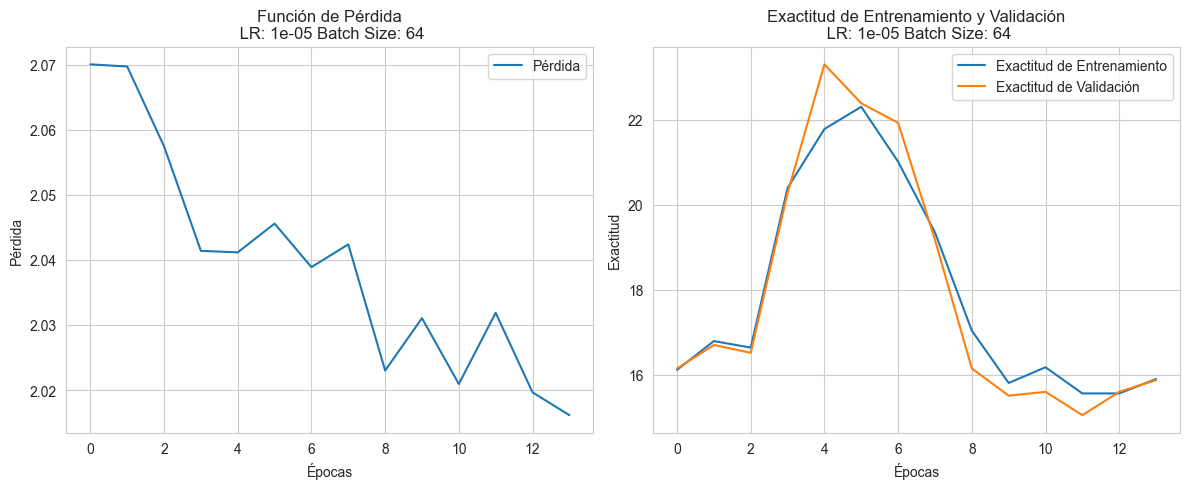

In [7]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim
from itertools import product

learning_rates = [0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]
batch_sizes = [32, 64]
epochs_list = [15, 30]

resultados = []
modelos = {}

for lr, batch_size, epochs in product(learning_rates, batch_sizes, epochs_list):

    # Crear DataLoaders para los datos de entrenamiento, validación y test
    dataloader_entrenamiento = DataLoader(dataset_entrenamiento, batch_size=batch_size, shuffle=True)
    dataloader_validacion = DataLoader(dataset_validacion, batch_size=batch_size, shuffle=False)
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    modelo = ConvNet().to(device)
    criterio = nn.CrossEntropyLoss()
    optimizador = optim.Adam(modelo.parameters(), lr=lr)
    scheduler = StepLR(optimizador, step_size=10, gamma=0.5)

    combinacion = (lr, batch_size, epochs)
    print(f"\nEntrenando con lr={lr}, batch_size={batch_size}, epochs={epochs}")

    modelos[combinacion] = modelo

    valores_perdida = []
    exactitud_entrenamiento = []
    exactitud_validacion = []

    early_stopping = EarlyStopping(patience=5, delta=0.01)

    for epoca in range(epochs):
        modelos[combinacion].train()
        running_loss = 0.0
        for images, labels in dataloader_entrenamiento:
            images, labels = images.to(device), labels.to(device)
            outputs = modelos[combinacion](images)
            loss = criterio(outputs, labels)
            loss.backward()
            optimizador.step()
            optimizador.zero_grad()
            running_loss += loss.item()

        valores_perdida.append(running_loss / len(dataloader_entrenamiento))

        with torch.no_grad():
            modelos[combinacion].eval()

            # Calcular exactitud de entrenamiento
            correctas = 0
            total = 0
            for images, labels in dataloader_entrenamiento:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_entrenamiento.append(100 * correctas / total)

            # Calcular exactitud de validación
            correctas = 0
            total = 0
            for images, labels in dataloader_validacion:
                images, labels = images.to(device), labels.to(device)
                outputs = modelos[combinacion](images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correctas += (predicted == labels).sum().item()
            exactitud_validacion.append(100 * correctas / total)
        
        scheduler.step()
        
        # Early stopping
        val_loss = valores_perdida[-1]  # Usamos la pérdida más reciente
        early_stopping(val_loss, modelo)

        # Verifica si se activa la parada anticipada
        if early_stopping.early_stop:
            print("Parada anticipada activada")
            modelo.load_state_dict(early_stopping.best_model_wts)  # Cargar los mejores pesos
            break

        # Imprimir métricas de la época
        print(f'    Época {epoca+1}, pérdida: {val_loss:.4f}, exactitud entrenamiento: {exactitud_entrenamiento[-1]:.2f}%, exactitud validación: {exactitud_validacion[-1]:.2f}%')
        
        for param_group in optimizador.param_groups:
            print(f"Learning rate actual: {param_group['lr']:.6f}")

    graficar_perdida_entrenamiento_validacion(lr, batch_size, epochs, valores_perdida, exactitud_entrenamiento, exactitud_validacion)
    resultados.append((lr, batch_size, epochs, exactitud_validacion[-1]))


Top configuraciones:
    LR=0.005, Batch=64, Epochs=30, Exactitud validación=84.22%
    LR=0.001, Batch=32, Epochs=30, Exactitud validación=83.49%
    LR=0.0005, Batch=64, Epochs=30, Exactitud validación=83.12%
    LR=0.005, Batch=32, Epochs=30, Exactitud validación=82.39%
    LR=0.001, Batch=64, Epochs=30, Exactitud validación=81.19%

Exactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR=0.005, Batch=64, Epochs=30    : 80.89%
Reporte de clasificación:
              precision    recall  f1-score   support

           0     0.6888    0.9060    0.7826       149
           1     0.8917    0.9211    0.9061       152
           2     0.7039    0.8456    0.7683       149
           3     0.8767    0.7399    0.8025       173
           4     0.8726    0.9133    0.8925       150
           5     0.7377    0.6040    0.6642       149
           6     0.9587    0.7436    0.8375       156

    accuracy                         0.8089      1078
   macro avg     0.8186    

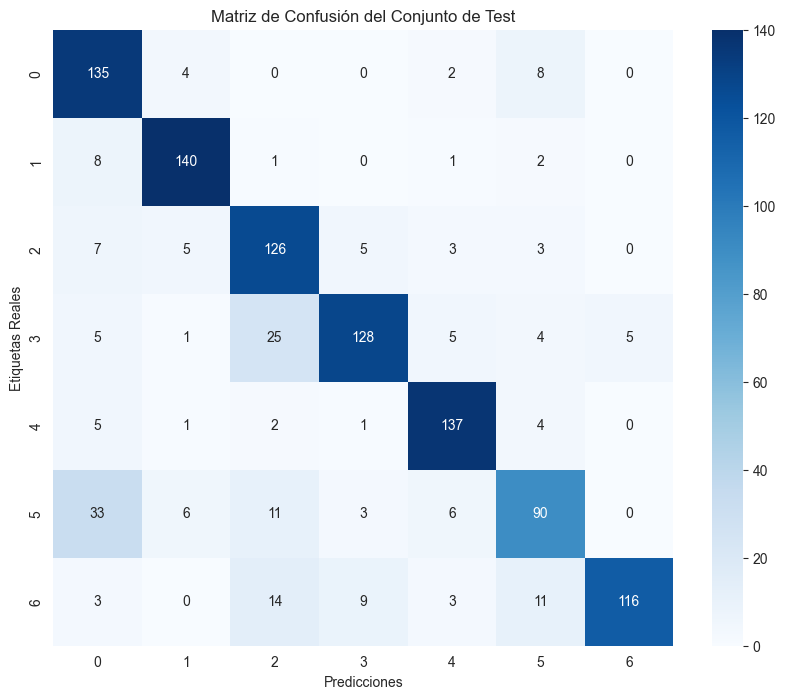

Clases presentes en el conjunto de test: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}


In [8]:
mejores_resultados = sorted(resultados, key=lambda x: x[3], reverse=True)
print("Top configuraciones:")
for res in mejores_resultados[:5]:
    print(f"    LR={res[0]}, Batch={res[1]}, Epochs={res[2]}, Exactitud validación={res[3]:.2f}%")

mejor = (mejores_resultados[0][0], mejores_resultados[0][1], mejores_resultados[0][2])
modelo = modelos[mejor]
exactitud_test = calcular_exactitud_test(modelo, dataloader_test, device)
print(f"\nExactitud del modelo en el conjunto de test para el conjunto de hiperprámetros LR={mejor[0]}, Batch={mejor[1]}, Epochs={mejor[2]}    : {exactitud_test:.2f}%")
matriz_de_confusion(modelo, dataloader_test, device)